##Предсказание оттока пользователей (соревнование на Kaggle)

В этой задаче предстоит моделировать отток клиентов телеком компании. Эта задача очень важна на практике и алгоритмы для ее решения используются в реальных телеком компаниях, ведь если мы знаем, что клиент собирается уйти от нас, то мы попытаемся удержать его, предложив какие-то бонусы.

У нас есть файл с тренировочными данными - train.csv (содержит колонки признаков и целевую переменную) и файл с тестовыми данными - test.csv (содержит только колонку с целевой переменной). В качестве ответа необходимо загрузить предсказания вероятностей ухода клиентов для test.csv в отдельный файл submission.csv.

## 1. Метрика

Перед решением любой задачи важно понимать, как будет оцениваться решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить, используя только предсказанные вероятности и истинные классы без конкретного порога классификации. К тому же она работает, даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров другого). Именно поэтому она очень удобна для соревнований.

Подключим необходимую библиотеку:


In [1]:
from sklearn.metrics import roc_auc_score, roc_curve

##2. Загрузка и исследование данных

Импортируем библиотеки

*pandas* (возможность хранить данные в виде таблицы)

*numpy* (работа с векторами и матрицами)

*matplotlib.pyplot* (визуализация данных в виде графиков, гистограм и др.)

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

Загрузим тренировочные данные:

In [3]:
train_data = pd.read_csv('https://raw.githubusercontent.com/KostyaDavydov/Clients_Outflow/master/train.csv')

Выведем на экран краткое описание столбцов таблицы:

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

Столбец TotalSpent показывает, сколько клиент заплатил нам за всё время пользования нашими услугами. Он имеет тип object. Для наших дальнейших нужд поменяем этот тип на float:

In [9]:
train_data["TotalSpent"] = pd.to_numeric(train_data["TotalSpent"], downcast="float", errors="coerce")

Проверим, что тип столбца TotalSpent действительно изменился:

In [10]:
train_data["TotalSpent"].dtype

dtype('float32')

Выведем на экран информацию о некоторых клиентах (каждому клиенту соответствует одна строчка в таблице):

In [11]:
train_data.loc[np.sort(np.random.randint(0, train_data.shape[0], size=10))]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
118,23,95.10,2326.050049,Female,1,Yes,No,Yes,No,Fiber optic,Yes,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,0
910,72,74.40,5360.750000,Male,1,Yes,No,Yes,No,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Bank transfer (automatic),0
1073,1,35.90,35.900002,Male,0,No,No,No,No phone service,DSL,No,No,No,No,No,Yes,Month-to-month,No,Electronic check,1
2319,1,44.05,44.049999,Male,0,No,No,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),0
2760,1,69.75,69.750000,Male,1,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,1
3343,5,24.30,100.199997,Male,0,No,No,No,No phone service,DSL,No,No,No,No,No,No,Month-to-month,No,Mailed check,0
4037,53,105.55,5682.250000,Female,0,No,No,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Two year,No,Electronic check,0
4530,1,45.30,45.299999,Male,0,No,No,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,No,Electronic check,1
5101,41,111.15,4507.149902,Male,0,No,Yes,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,0
5258,54,105.20,5637.850098,Male,0,Yes,Yes,Yes,Yes,Fiber optic,No,Yes,No,Yes,Yes,Yes,One year,Yes,Electronic check,0


Посмотрим, есть ли в датасете незаполненные значения (значения NaN):

In [12]:
nanCounts = train_data[:].isna().sum() #Ищем значения NaN в каждом столбце (подсчитываем их число)
nanCountsDF = pd.DataFrame(nanCounts)
nanCountsDF.reset_index(inplace = True) #inplace = True - чтобы изменять DataFrame сразу, а не создавать ещё один
nanCountsDF.rename(columns = {"index" : "Column", 0 : "Amount of NaNs"}, inplace = True)
nanCountsDF

,Column,Amount of NaNs
0,ClientPeriod,0
1,MonthlySpending,0
2,TotalSpent,9
3,Sex,0
4,IsSeniorCitizen,0
5,HasPartner,0
6,HasChild,0
7,HasPhoneService,0
8,HasMultiplePhoneNumbers,0
9,HasInternetService,0


В столбце TotalSpent у 9 клиентов стоит значение типа NaN. Отобразим информацию об этих клиентах:

In [13]:
train_data[train_data.isnull().any(1)]

<ipython-input-13-f89ca31cff06>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  train_data[train_data.isnull().any(1)]


,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,NaN,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,NaN,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,NaN,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,NaN,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,NaN,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,NaN,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,NaN,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,NaN,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,NaN,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


Как видно, у каждого из этих клиентов в первом столбце ClientPeriod (то, сколько месяцев клиент пользуется услугами) везде нули, что означает, что все эти клиенты новые и не успели ещё ничего потратить.

Отсюда делаем вывод, что в столбце TotalSpent можем для них задать значение 0:

In [14]:
train_data["TotalSpent"] = train_data["TotalSpent"].fillna(0)

Проверим, что значений типа NaN больше нет, подсчитав их количество в столбце TotalSpent:

In [15]:
train_data["TotalSpent"].isna().sum()

0

Для дальнейшей работы с данными выделим в отдельные списки имена столбцов, соответствующих числовым признакам и категориальным, а также занесём в отдельную переменную название столбца с целевой переменной:

In [17]:
#Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

#Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

## 3. Визуализация данных

Построим гистограмму распределения для каждого числового признака:

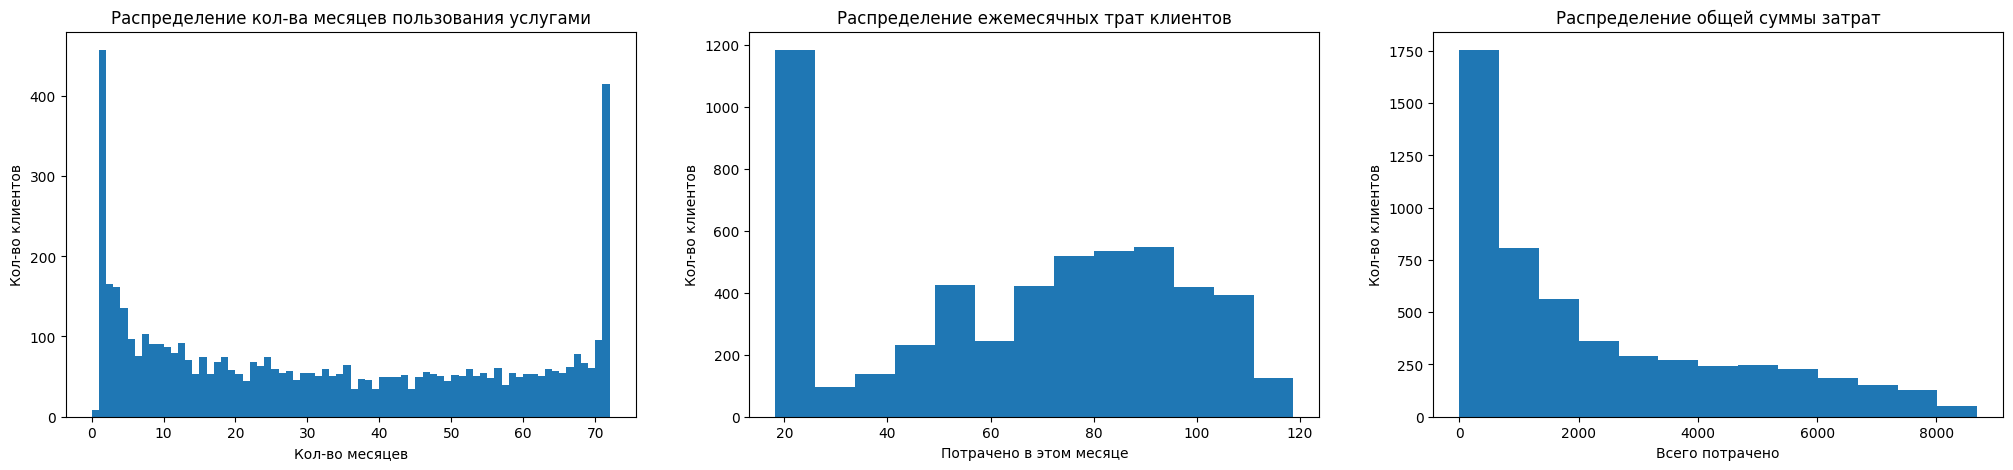

In [19]:
plt.figure(figsize=(25, 5))

plt.subplot(1, 3, 1)
plt.hist(train_data[num_cols[0]], bins = max(train_data[num_cols[0]])-min(train_data[num_cols[0]]))
plt.gca().set(title = 'Распределение кол-ва месяцев пользования услугами', xlabel = 'Кол-во месяцев', ylabel = 'Кол-во клиентов')

plt.subplot(1, 3, 2)
plt.hist(train_data[num_cols[1]], bins = 1 + int(np.trunc(np.log2(len(train_data[num_cols[1]])))))
plt.gca().set(title = 'Распределение ежемесячных трат клиентов', xlabel = 'Потрачено в этом месяце', ylabel = 'Кол-во клиентов')

plt.subplot(1, 3, 3)
plt.hist(train_data[num_cols[2]], bins = 1 + int(np.trunc(np.log2(len(train_data[num_cols[1]])))))
plt.gca().set(title = 'Распределение общей суммы затрат', xlabel = 'Всего потрачено', ylabel = 'Кол-во клиентов')


plt.show()

Обработаем столбцы с категориальными признаками.
Найдём уникальные значения в стобце Sex и их количество в этом столбце:

In [20]:
valChars = train_data["Sex"].value_counts()
valChars

Male      2655
Female    2627
Name: Sex, dtype: int64

А теперь разобьём эту информацию на два списка:

In [22]:
vals = valChars.index.to_list()
vals

['Male', 'Female']

Посмотрим, сколько объектов имеют каждое из значений:

In [23]:
counts = valChars.to_list()
counts

[2655, 2627]

Обработаем так же каждый столбец с категориальным признаком, выводя при этом круговые диаграммы, показывающие частоту встречаемости значений:

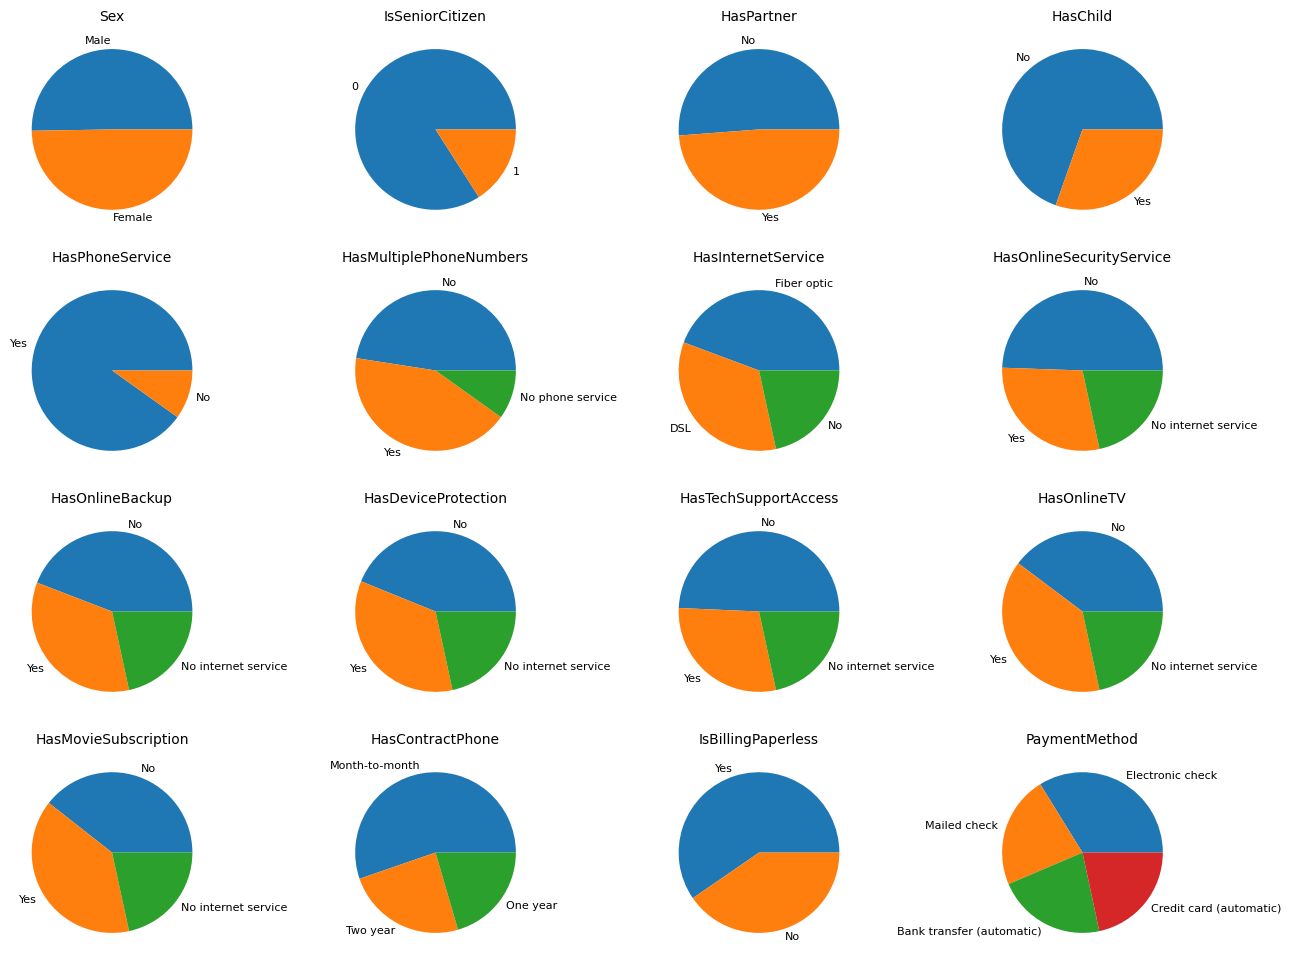

In [24]:
plt.figure(figsize = (16, 12))

i = 1
for currCol in cat_cols:
    valChars = train_data[currCol].value_counts()
    vals = valChars.index.to_list()
    counts = valChars.to_list()

    plt.subplot(4, 4, i)
    plt.pie(counts, labels = vals, textprops = {"fontsize" : 8})
    plt.title(currCol, {"fontsize" : 10})
    i += 1


plt.show()

Посмотрим на распределение целевой переменной:

<BarContainer object of 2 artists>

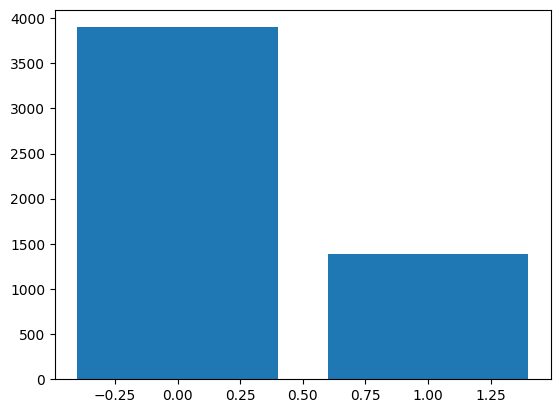

In [25]:
valChars = train_data[target_col].value_counts()
vals = valChars.index.to_list()
counts = valChars.to_list()

plt.bar(vals, counts)

Как видно — классы целевой переменной довольно не сбалансированны: значений класса 0 примерно в 3 раза больше, чем значений класса 1:

In [26]:
counts[0] / counts[1]

2.816473988439306

Но так как мы используем метрику ROC-AUC, то сейчас это не проблема для нас.

## 4. Применение линейных моделей

Обработаем данные, чтобы к ним можно было применить LogisticRegression: закодируем категориальные признаки с помощью one-hot-encoding'а.

Подключим необходимые библиотеки:

In [27]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder

Проведём подготовку данных, выделим обучающие признаки и целевую переменную, подготовим тестовую выборку для контроля качества данных.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(train_data.iloc[:, :-1], train_data[target_col], test_size = 0.2)

Закодируем категориальные признаки с помощью процедуры one-hot-encoding:

In [30]:
categorical_data = X_train.loc[:, X_train.columns.isin(cat_cols)]
dummy_data = pd.get_dummies(categorical_data)
dummy_data

,IsSeniorCitizen,Sex_Female,Sex_Male,HasPartner_No,HasPartner_Yes,HasChild_No,HasChild_Yes,HasPhoneService_No,HasPhoneService_Yes,HasMultiplePhoneNumbers_No,...,HasMovieSubscription_Yes,HasContractPhone_Month-to-month,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_No,IsBillingPaperless_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
1937,0,0,1,1,0,0,1,0,1,1,...,1,0,1,0,1,0,0,0,0,1
1212,0,1,0,1,0,1,0,0,1,0,...,1,1,0,0,1,0,0,0,1,0
512,0,1,0,0,1,0,1,0,1,1,...,0,0,0,1,0,1,0,1,0,0
2854,1,1,0,1,0,1,0,0,1,0,...,1,1,0,0,0,1,0,0,1,0
681,0,1,0,0,1,1,0,0,1,1,...,0,0,0,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1736,1,0,1,0,1,1,0,0,1,1,...,0,0,1,0,0,1,0,1,0,0
787,0,1,0,0,1,0,1,0,1,0,...,0,0,0,1,0,1,1,0,0,0
5120,1,0,1,1,0,1,0,0,1,1,...,1,1,0,0,0,1,1,0,0,0
890,0,0,1,1,0,1,0,0,1,1,...,0,1,0,0,1,0,0,1,0,0


Выделим в отдельный DataFrame столбцы с числовыми признаками:

In [31]:
numeric_data = X_train.loc[:, X_train.columns.isin(num_cols)]
numeric_data

,ClientPeriod,MonthlySpending,TotalSpent
1937,15,64.85,950.750000
1212,30,100.45,3096.899902
512,55,69.05,3842.600098
2854,28,103.30,2890.649902
681,61,20.25,1278.800049
...,...,...,...
1736,59,82.95,4903.149902
787,23,77.15,1759.400024
5120,65,99.10,6496.149902
890,16,19.75,294.899994


Сохраним исходный DataFrame с тренировочными данными в переменную *X_train_origin*, а в переменную *X_train* запишем обработанные признаки:

In [32]:
X_train_origin = X_train
X_train = pd.concat([numeric_data, dummy_data], axis = 1)
X_train.head()

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Sex_Female,Sex_Male,HasPartner_No,HasPartner_Yes,HasChild_No,HasChild_Yes,...,HasMovieSubscription_Yes,HasContractPhone_Month-to-month,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_No,IsBillingPaperless_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
1937,15,64.85,950.750000,0,0,1,1,0,0,1,...,1,0,1,0,1,0,0,0,0,1
1212,30,100.45,3096.899902,0,1,0,1,0,1,0,...,1,1,0,0,1,0,0,0,1,0
512,55,69.05,3842.600098,0,1,0,0,1,0,1,...,0,0,0,1,0,1,0,1,0,0
2854,28,103.30,2890.649902,1,1,0,1,0,1,0,...,1,1,0,0,0,1,0,0,1,0
681,61,20.25,1278.800049,0,1,0,0,1,1,0,...,0,0,0,1,1,0,0,1,0,0


Сделаем такую же процедуру и с тестовыми данными:

In [33]:
categorical_data = X_test.loc[:, X_test.columns.isin(cat_cols)]
dummy_data = pd.get_dummies(categorical_data)
dummy_data

,IsSeniorCitizen,Sex_Female,Sex_Male,HasPartner_No,HasPartner_Yes,HasChild_No,HasChild_Yes,HasPhoneService_No,HasPhoneService_Yes,HasMultiplePhoneNumbers_No,...,HasMovieSubscription_Yes,HasContractPhone_Month-to-month,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_No,IsBillingPaperless_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
42,0,0,1,0,1,0,1,0,1,1,...,1,0,0,1,1,0,0,0,1,0
3289,0,0,1,1,0,1,0,0,1,1,...,0,1,0,0,0,1,0,0,1,0
1592,0,1,0,0,1,0,1,0,1,0,...,1,0,1,0,0,1,0,1,0,0
5178,0,0,1,0,1,0,1,0,1,1,...,0,1,0,0,0,1,0,0,1,0
1383,0,0,1,0,1,0,1,0,1,1,...,1,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1823,0,1,0,1,0,1,0,0,1,0,...,1,0,1,0,1,0,0,0,1,0
3636,0,0,1,1,0,1,0,0,1,0,...,0,0,0,1,1,0,1,0,0,0
4322,1,0,1,0,1,1,0,0,1,0,...,0,0,1,0,0,1,0,0,1,0
377,0,1,0,0,1,0,1,0,1,0,...,1,0,0,1,0,1,0,1,0,0


In [34]:
numeric_data = X_test.loc[:, X_test.columns.isin(num_cols)]
numeric_data

,ClientPeriod,MonthlySpending,TotalSpent
42,62,86.10,5215.250000
3289,10,45.55,402.600006
1592,61,100.70,6018.649902
5178,6,49.15,295.649994
1383,2,97.10,184.149994
...,...,...,...
1823,70,98.90,6838.600098
3636,62,69.40,4237.500000
4322,53,60.05,3229.649902
377,65,110.80,7245.899902


In [35]:
X_test_origin = X_test
X_test = pd.concat([numeric_data, dummy_data], axis = 1)
X_test.head()

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Sex_Female,Sex_Male,HasPartner_No,HasPartner_Yes,HasChild_No,HasChild_Yes,...,HasMovieSubscription_Yes,HasContractPhone_Month-to-month,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_No,IsBillingPaperless_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
42,62,86.10,5215.250000,0,0,1,0,1,0,1,...,1,0,0,1,1,0,0,0,1,0
3289,10,45.55,402.600006,0,0,1,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0
1592,61,100.70,6018.649902,0,1,0,0,1,0,1,...,1,0,1,0,0,1,0,1,0,0
5178,6,49.15,295.649994,0,0,1,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0
1383,2,97.10,184.149994,0,0,1,0,1,0,1,...,1,1,0,0,1,0,0,0,1,0


Протестируем разные значения гиперпараметра C и выберем лучший по метрике ROC-AUC:

In [36]:
CVmodel = LogisticRegressionCV(Cs = [1000, 100, 10, 1, 0.1, 0.01, 0.001],
                               penalty = 'l2',
                               scoring = 'roc_auc',
                               max_iter = 100,
                               n_jobs = -1,
                               refit = True
                               ).fit(X_train, y_train)

In [37]:
y_test_predicted = CVmodel.predict_proba(X_test)[:, 1]

In [38]:
y_test_predicted

array([0.01047115, 0.4141657 , 0.07597693, ..., 0.03961561, 0.08912975,
       0.00882647])

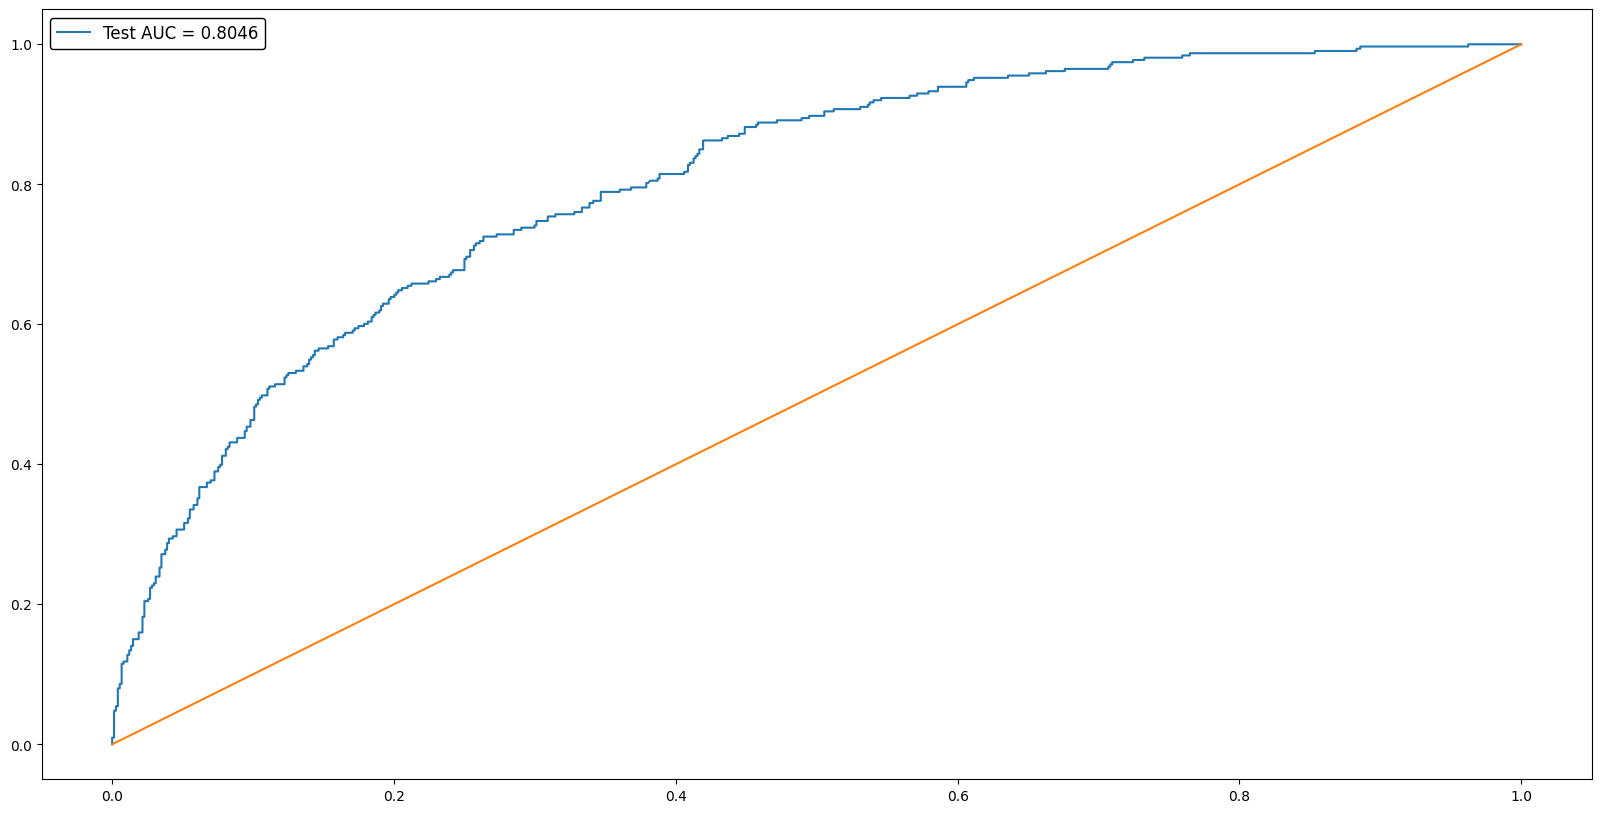

In [39]:
test_auc = roc_auc_score(y_test.values, y_test_predicted)

plt.figure(figsize = (20, 10))
plt.plot(*roc_curve(y_test.values, y_test_predicted)[:2], label = "Test AUC = {:.4f}".format(test_auc))
legend_box = plt.legend(fontsize = "large", framealpha = 1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
plt.show()

In [40]:
print(CVmodel.C_)
print(test_auc)

[0.1]
0.8045814868253804


Удалось добиться качества 0.805 при параметре C = 0.1.

## 5. Применение градиентного бустинга

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. Catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А числовые признаки нормировать для моделей, основанных на деревьях, не нужно.

In [43]:
!pip install catboost

In [44]:
import catboost

Разделим выборку на train/valid и протестируем catboost cо стандартными параметрами.

In [45]:
X_GB = train_data.iloc[:, :-1]
X_GB.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
0,55,19.50,1026.349976,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check
1,72,25.85,1872.199951,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic)
2,1,75.90,75.900002,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check
3,32,79.30,2570.000000,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check
4,60,115.25,6758.450195,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic)


In [46]:
y_GB = train_data.iloc[:, -1]
y_GB

0       0
1       0
2       1
3       0
4       0
       ..
5277    0
5278    0
5279    0
5280    0
5281    0
Name: Churn, Length: 5282, dtype: int64

In [47]:
X_train_GB, X_test_GB, y_train_GB, y_test_GB = train_test_split(X_GB, y_GB, test_size = 0.2, random_state = 42)

In [49]:
cat_cols_indices = list(range(3, X_GB.shape[1])) #выделим индексы столбцов с категориальными признаками в отдельный список
cat_cols_indices

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

In [50]:
boosting_model = catboost.CatBoostClassifier(n_estimators = 200,
                                             cat_features = cat_cols_indices)

boosting_model.fit(X_train_GB, y_train_GB)

y_train_pred = boosting_model.predict_proba(X_train_GB)[:, 1]
y_test_pred = boosting_model.predict_proba(X_test_GB)[:, 1]

Learning rate set to 0.083391
0:	learn: 0.6382749	total: 79.2ms	remaining: 15.8s
1:	learn: 0.5970973	total: 109ms	remaining: 10.8s
2:	learn: 0.5610080	total: 134ms	remaining: 8.81s
3:	learn: 0.5329491	total: 164ms	remaining: 8.02s
4:	learn: 0.5112068	total: 194ms	remaining: 7.55s
5:	learn: 0.4930985	total: 229ms	remaining: 7.41s
6:	learn: 0.4800850	total: 245ms	remaining: 6.76s
7:	learn: 0.4681540	total: 281ms	remaining: 6.74s
8:	learn: 0.4583285	total: 304ms	remaining: 6.46s
9:	learn: 0.4494858	total: 335ms	remaining: 6.37s
10:	learn: 0.4439489	total: 364ms	remaining: 6.25s
11:	learn: 0.4371125	total: 398ms	remaining: 6.23s
12:	learn: 0.4311122	total: 432ms	remaining: 6.22s
13:	learn: 0.4264039	total: 454ms	remaining: 6.04s
14:	learn: 0.4222915	total: 475ms	remaining: 5.86s
15:	learn: 0.4190003	total: 507ms	remaining: 5.84s
16:	learn: 0.4153313	total: 536ms	remaining: 5.77s
17:	learn: 0.4132986	total: 553ms	remaining: 5.59s
18:	learn: 0.4116653	total: 576ms	remaining: 5.49s
19:	learn:

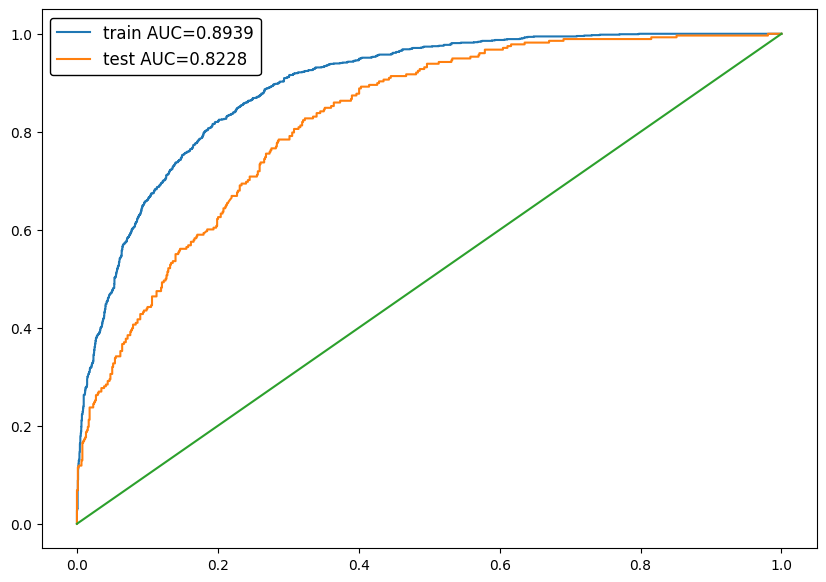

In [51]:
train_auc = roc_auc_score(y_train_GB, y_train_pred)
test_auc = roc_auc_score(y_test_GB, y_test_pred)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train_GB, y_train_pred)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test_GB, y_test_pred)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

Удалось получить качество 0.823

## 6. Предсказания

Для предсказаний на тестовых данных будем использовать лучшую из проверенных моделей.

Градиентный бустинг дал лучший результат, поэтому будем использовать именно его:

In [59]:
best_model = boosting_model

In [60]:
X_test = pd.read_csv('https://raw.githubusercontent.com/KostyaDavydov/Clients_Outflow/master/test.csv')
submission = pd.read_csv('https://raw.githubusercontent.com/KostyaDavydov/Clients_Outflow/master/submission.csv')

Делаем предсказания на тестовых данных и записываем результат в итоговый файл:

In [61]:
submission['Churn'] = best_model.predict_proba(X_test)[:, 1]
submission.to_csv('./my_submission.csv', index = False)